# Extracting events given location and wind thresholds

This code does stuff...

By Claire Krause, October 2017. Python v2. TCRM branch `develop` (but should be applicable to other branches).

**Required inputs**
- This code requires access to TCRM modules (e.g. `database`, `Utilities.`). Make sure the the TCRM directory is in the python path so these modules can be found and imported
- TCRM configuration file. This will tell the code where to look for the hazard and location databases.
- This code assumes that hazard and location databases have already been created. This code does not produce these databases.
- Dict of locations for which you would like to extract events that meet a given wind speed and distance threshold. This dict is defined within the code, and does not need to be imported.

## Set up the notebook imports

In [1]:
%pylab notebook
from __future__ import print_function, division

Populating the interactive namespace from numpy and matplotlib


In [2]:
import database
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import statsmodels.api as sm
from math import cos, asin, sqrt
import os
import pickle
import cartopy.crs as ccrs
import cartopy.feature as feature
#from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset

from Utilities.config import ConfigParser
from Utilities.lmomentFit import samlmu, pelgev, pelgpa
from Utilities.track import ncReadTrackData

# Import widgets for interactive notebook
from ipywidgets import interact, fixed
import ipywidgets as widgets

import seaborn as sns
sns.set_context("poster")
sns.set_style("whitegrid")

In [3]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

def loadTrack(trackId):
    trackNum, trackYear = int(trackId.split('-')[0]), int(trackId.split('-')[1])
    trackFile = os.path.join(outputPath, 'tracks', 'tracks.{0:05d}.nc'.format(trackYear))
    tracks = ncReadTrackData(trackFile)
    
    return [t for t in tracks if t.trackId==(trackNum, trackYear)][0]

def getTracks(recs):
    tracks = []
    for rec in recs:
        trackId = rec['eventId']
        track = loadTrack(trackId)
        tracks.append(track)
    return tracks

def plot_tracks(gridLimit, tracks):
    '''
    Plot all of the tracks contained within the 'tracks' object
    '''
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.add_feature(feature.BORDERS)
    gl = ax.gridlines(linestyle=":", draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    ax.set_xlim((gridLimit['xMin'], gridLimit['xMax']))
    ax.set_ylim((gridLimit['yMin'], gridLimit['yMax']))
    for track in tracks:
        plt.plot(track.Longitude, track.Latitude)
    return fig, ax

## Set up the hazard database instance
Point to the configuration file used to produce the database

In [4]:
#configFile = "/g/data/w85/cek156/db10kyr/tcrm2.0.ini"
configFile = 'C:/Users/u37443/TCRM/output/port_hedland/Bodgy_config.ini'
config = ConfigParser()
config.read(configFile)

db = database.HazardDatabase(configFile)
locations = db.getLocations()
locNameList = list(locations['locName'])
outputPath = config.get('Output', 'Path')
gridLimit = config.geteval('Region', 'gridLimit')

No handlers could be found for logger "root"


# Find events that meet distance and speed thresholds

The extraction uses the `locationPassageWindSpeed` function within the `database` module in TCRM

For the DFES severe wind project, the following TCs will be considered:
- Cat 5: Broome, Port Hedland, Dampier/Karratha, Exmouth
- Cat 3: Broome, Port Hedland, Dampier/Karratha, Exmouth, Geraldton, Carnarvon, Perth
- Cat 1: Geraldton, Carnarvon, Perth
- ETT: Perth

In [18]:
# Set up the thresholds for the different TC categories
TC_thresholds = {'category 3': 50, 'category 4': 60, 'category 5': 70}

#Set the distance threshold for locating TCs
dist_thr = 100

## We will start with Cat 5 storms

In [19]:
strength = 'category 5'
speed_thr = TC_thresholds[strength]

## Set up the location/s that you would like to analyse

Set up a dict of the locations for which you would like to do the analysis. This dict should include the location name as the keys, and a list of [lat, lon] as the associated data.

In [22]:
locations_to_analyse = {'Broome': [-17.952, 122.232], 'Port Hedland': [-20.310, 118.591], 
                        'Dampier/Karratha': [-20.704, 116.767], 'Exmouth': [-21.943, 114.134]}

name_list = []
for locs in locations_to_analyse:
    locsloc = locations_to_analyse[locs]
    listloc = [locations['locLat'], locations['locLon']]    
    temp_list = []
    for num in range(len(listloc[0])):
        temp_list.append(distance(locsloc[0], locsloc[1], listloc[0][num], listloc[1][num]))
    min_dist = temp_list.index(min(temp_list))
    name_list.append(locations[min_dist])
name_list

[(10720, u'Learmonth Airport', 114.08333, -22.23333),
 (10728, u'Port Hedland Bedout Island Aws', 119.1, -19.58333),
 (10671, u'Broome Airport', 122.21667, -17.95),
 (11188, u'Karratha Aerodrome Aws', 116.76667, -20.71667)]

## See if there is a pickle file for this database search before re-doing it...

Just analyse the first location for now...

In [8]:
output_filename = 'C:/Users/u37443/TCRM/output/port_hedland/location_tcCats/{0}_{1}_pkl'.format(str(name_list[0][0]), strength)
try:
    with open(output_filename, 'rb') as file:
        extreme_events = pickle.load(file) # this only takes tens of seconds. (6GB)
except:
    extreme_events = database.locationPassageWindSpeed(db, str(name_list[0][0]), speed_thr, dist_thr)
    # To save performing a database search each time, we will pickle out the results to make it quicker to run next time
    with open(output_filename, 'wb') as file:
        pickle.dump(extreme_events, file, protocol=-1) # save result to disk
tracks = getTracks(extreme_events)

In [9]:
pd.DataFrame(extreme_events)

,locName,wspd,umax,vmax,eventId,distClosest,maxwind,pmin
0,Learmonth Airport,72.095276,-63.454918,34.222839,007-00135,6.367527,80.893715,89575.007812
1,Learmonth Airport,76.398849,-26.057201,71.817871,000-00009,14.506997,79.485275,90910.960938


## Plot up the tracks identified, and select the track for further analysis 

<IPython.core.display.Javascript object>


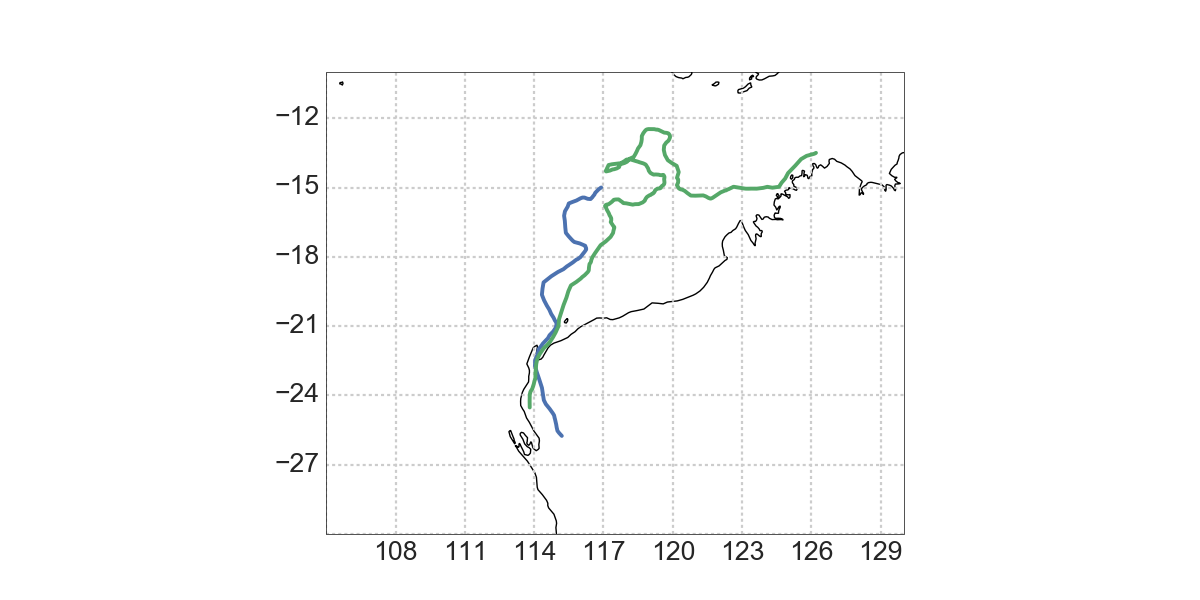

The installed widget Javascript is the wrong version.


In [12]:
fig, ax = plot_tracks(gridLimit, tracks)  

w = widgets.HTML("Click on the track you would like to identify")
def onclick(event):
    global Lon, Lat
    Lon, Lat = event.xdata, event.ydata
    w.value = 'Lon: {}, Lat: {}'.format(Lon, Lat) 
cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

## Find out which track was selected

In [13]:
Diffs = []
for track in tracks:
    min_val = min(abs(Lon - track.Longitude) + abs(Lat - track.Latitude))
    Diffs.append(min_val)
ix = Diffs.index(min(Diffs))
first, second = tracks[ix].trackId
first = str(first).zfill(3)
second = str(second).zfill(5)
eventid = '{0}-{1}'.format(first, second)
chosen = pd.DataFrame(extreme_events[extreme_events['eventId'] == eventid])
chosen

,locName,wspd,umax,vmax,eventId,distClosest,maxwind,pmin
0,Learmonth Airport,76.398849,-26.057201,71.817871,000-00009,14.506997,79.485275,90910.960938


## Read in the windfield for the chosen event

In [14]:
gust_filename = 'C:/Users/u37443/TCRM/output/port_hedland/windfield/gust.{0}.nc'.format(str(chosen.eventId[0]))
nc = Dataset(gust_filename)
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
vmax = nc.variables['vmax'][:][:]

<IPython.core.display.Javascript object>


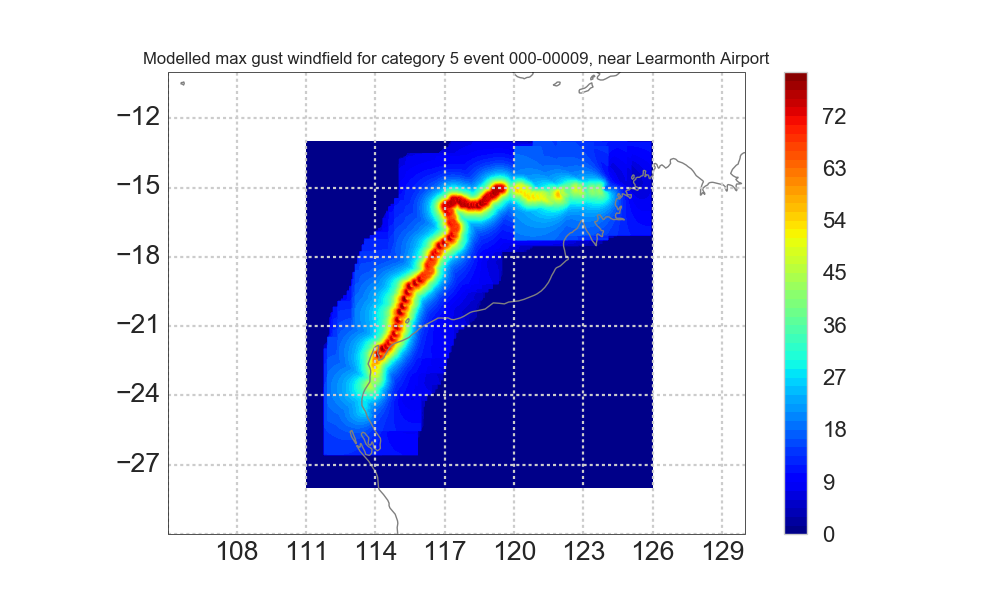

In [37]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='grey', linewidth=1)
ax.add_feature(feature.BORDERS)
gl = ax.gridlines(linestyle=":", draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False

ax.set_xlim((gridLimit['xMin'], gridLimit['xMax']))
ax.set_ylim((gridLimit['yMin'], gridLimit['yMax']))
plt.contourf(lon, lat, vmax, 60, transform=ccrs.PlateCarree(), cmap = get_cmap("jet"))
plt.title('Modelled max gust windfield for {0} event {1}, near {2}'.format(strength, str(chosen.eventId[0]), 
                                                                           str(chosen.locName[0])), size=12)
ax.set_xlabel('Longitude', fontsize = 10)
ax.set_ylabel('Latitude', fontsize = 10)
plt.colorbar(ax=ax)

plt.show()